# Outline  
[Setup environment](#setup_environement)  
[Make DL model](#make_model)  
> [Libraries](#libraries)  
> [Data](#data)  
> [Model](#model)  

[Deploy model](#deploy)


## Setup environment<a id='setup_environement'> 

In the terminal.
* virtualenv:
    - go to the project folder
    - create virtualenv: virtualenv -p python2 venv_mnist  
    - don't forget to activate it: . venv_mnist/bin/activate  
    - install tensorflowjs: pip install tensorflowjs 
    - install keras: pip install keras==2.1.6  
    - pip freeze > requirements.txt  
    
* server which will serve models for the web-based UI:  
    - Install Node: brew install node  
    - Install http-server: npm install http-server -g  
    
* create a kernel to use with jupyter (inside the virtualenv):  
    - pip install ipykernel  
    - python -m ipykernel install --user --name=tensorflowjs_venv
    - pip freeze > requirements.txt


## Libraries<a id='libraries'>

In [1]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os

## Data<a id='data'>

In [4]:
batch_size = 128
num_classes = 10
epochs = 30

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

60000 train samples
10000 test samples


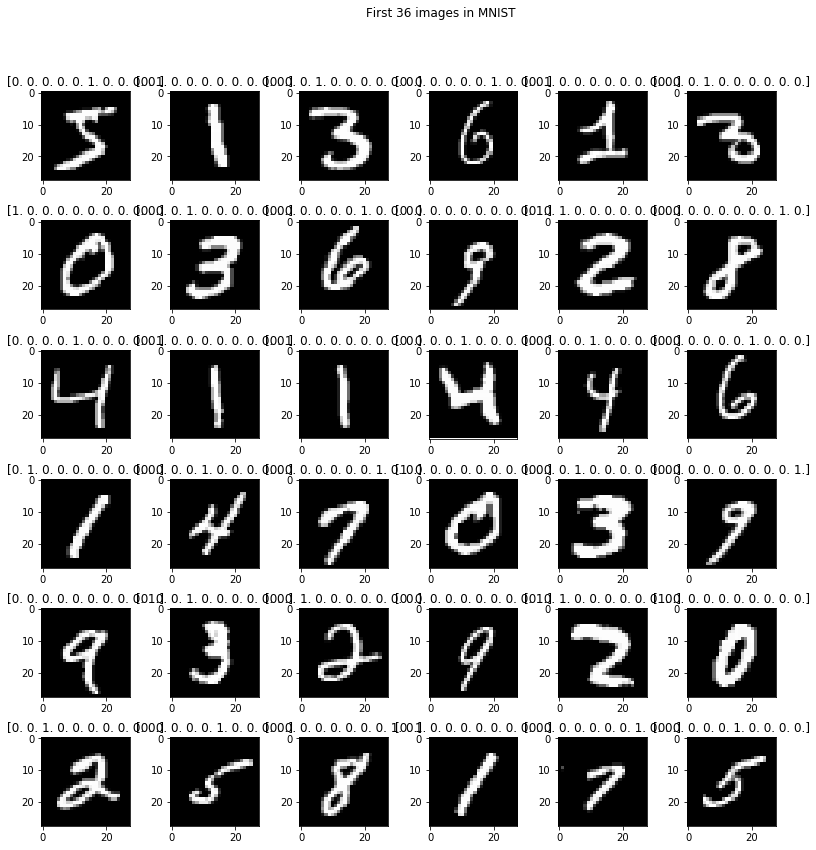

In [5]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(x_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(y_train[x + y * 6])

## Model<a id='model'>  

In [6]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 17s 277us/step - loss: 0.2460 - acc: 0.9243 - val_loss: 0.1263 - val_acc: 0.9599
Epoch 2/30
60000/60000 [==============================] - 18s 304us/step - loss: 0.1009 - acc: 0.9694 - val_loss: 0.0844 - val_acc: 0.9739
Epoch 3/30
60000/60000 [==============================] - 15s 254us/step - loss: 0.0772 - acc: 0.9768 - val_loss: 0.0846 - val_acc: 0.9757
Epoch 4/30
60000/60000 [==============================] - 15s 248us/step - loss: 0.0603 - acc: 0.9823 - val_loss: 0.0719 - val_acc: 0.9811
Epoch 5/30
60000/60000 [==============================] - 15s 249us/step - loss: 0.0526 - acc: 0.9845 - val_loss: 0.0869 - val_acc: 0.9772
Epoch 6/30
60000/60000 [==============================] - 16s 267us/step - loss: 0.0457 - acc: 0.9870 - val_loss: 0.0773 - val_acc: 0.9820
Epoch 7/30
60000/60000 [==============================] - 16s 261us/step - loss: 0.0371 - acc: 0.9887 - val_loss: 0.

In [14]:
# Save the model
MODEL_DIR = './models'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
model.save(os.path.join(MODEL_DIR,'mnistDense.h5'))

## Prediction    

In [9]:
img_test = x_test[0].reshape((1,784))
img_test.shape

(1, 784)

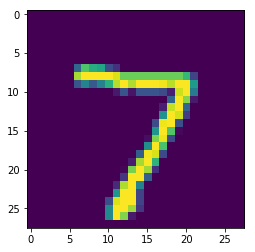

In [10]:
plt.imshow(img_test.reshape(28,-1))

In [11]:
prediction = model.predict_classes(img_test)

In [12]:
print('prediction: ', prediction)

prediction:  [7]


['acc', 'loss', 'val_acc', 'val_loss']


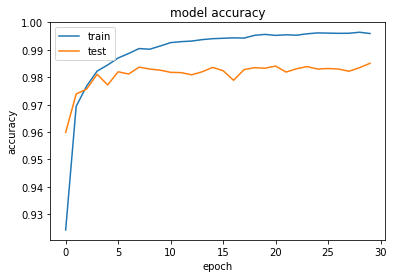

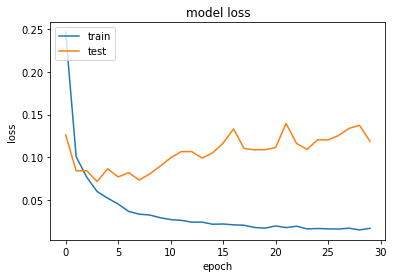

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Deploy model <a id='deploy'>  

* Convert keras models into tensorflowjs format:  
    - tensorflowjs_converter --input_format keras models/mnistDense.h5 models/
    
* Go to the models folder and serve the model (for web-based client):    
    - http-server -p 8787 -c1 --cors .  
    - Note down the link that we can use to serve our web, e.g: http://127.0.0.1:8787</model.json>. We will need this in our XXX.html file to load the model.  
* Make an html file to give web-based UI to get input and display the model's prediction.      

Acknowledgements
- https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py
- https://medium.com/coinmonks/handwritten-digit-prediction-using-convolutional-neural-networks-in-tensorflow-with-keras-and-live-5ebddf46dc8